In [1]:
from mpmath import re
from src.prepare_data import load_data_for_demographic, get_referendums, get_GPT_referendum_data, get_referendum_topics, get_referendum_topics_mapping, get_data_for_topic_modelling, get_GPT_federal_election_data, prepare_data_for_topic_modelling, reshape_topic_keywords, prepare_data_for_prediction
from src.prepare_data import parties, party_colors, languages

In [2]:
from src.models import get_prediction_model, evaluate_prediction_model, get_top_bottom_mnlogit_margeff, get_actual_pred

In [3]:
from src.plot_functions import plot_confusion_matrix, plot_mnlogit_coefficients_fancy

# Prepare data

In [4]:
election_topics = get_GPT_federal_election_data(data_folder='data')

In [5]:
df = load_data_for_demographic(data_folder='data')

40044
34559


In [6]:
topics_mapping = get_referendum_topics_mapping(data_folder='data')

In [7]:
df_topic = get_data_for_topic_modelling(df, election_topics['results'], data_folder='data')
df_topic.head(5)

,index,related,keyword 1,keyword 2,keyword 3,id,impressions_avg,page_name,lang,party_name
0,332742649438003,yes,Immigration & Asylum,Immigration & Asylum,National Security,332742649438003,4499.5,Piero Marchesi,italian,SVP
1,293494090302171,yes,Immigration & Asylum,Immigration & Asylum,National Security,293494090302171,5499.5,UDC Ticino,italian,SVP
2,733149895294821,yes,Governance & Politics,NaN,NaN,733149895294821,3499.5,UDC Ticino,italian,SVP
3,986383549088871,yes,Governance & Politics,NaN,NaN,986383549088871,3499.5,Marco Chiesa,italian,SVP
4,1147078399598805,yes,Governance & Politics,NaN,NaN,1147078399598805,5499.5,Piero Marchesi,italian,SVP


In [8]:
df_processed, topics = prepare_data_for_topic_modelling(df_topic)

In [9]:
df_party, party_mapping = prepare_data_for_prediction(df_processed, df, parties, topics)

In [10]:
df_party.head(5)

,impressions_avg,party_name,id,Agriculture_Food_Security,Business_Regulation,Civil_Liberties_Rights,Climate_Environment,Culture_Society,Democratic_Process,Digital_Transformation,...,18-24,25-34,35-44,45-54,55-64,65+,male,female,unknown,party_code
0,4499.5,SVP,332742649438003,0,0,0,0,0,0,0,...,0.027918,0.036061,0.092672,0.204730,0.298953,0.339667,0.469175,0.527336,0.003490,5
1,5499.5,SVP,293494090302171,0,0,0,0,0,0,0,...,0.046230,0.064225,0.085324,0.179956,0.285759,0.338505,0.355880,0.640085,0.004034,5
2,3499.5,SVP,733149895294821,0,0,0,0,0,0,0,...,0.019596,0.053603,0.103747,0.210375,0.297407,0.315274,0.588474,0.408646,0.002882,5
3,3499.5,SVP,986383549088871,0,0,0,0,0,0,0,...,0.021411,0.035265,0.088791,0.233628,0.287154,0.333753,0.553527,0.442067,0.004408,5
4,5499.5,SVP,1147078399598805,0,0,0,0,0,0,0,...,0.037357,0.129789,0.152299,0.183908,0.219349,0.277299,0.627873,0.370212,0.001916,5


# Predict

In [11]:
import pandas as pd

In [12]:
topics_names = [t.replace(' ', '_').replace('&', '').replace('__', '_').replace('+','') for t in topics]
demos = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'male', 'female']

data_test = {
    'Demographic': demos,
    'Topics': topics_names,
    'Demographic+Topics': demos + topics_names
}

In [13]:
data = pd.DataFrame(party_mapping.values(), columns=['party'])
data_coeff = {}

for features in data_test:
    print(f"\n{'#'*19} {features} {'#'*19}\n")
    fit, X, y_true = get_prediction_model(df_party, feature_cols=data_test[features], weights=True)

    # res, get_top_significant_odds_ratios = evaluate_model(df_party, party_mapping, fit)
    res, top_odds_ratios = evaluate_prediction_model(df_party, X, party_mapping, fit, top_head=100)
    data = data.merge(pd.DataFrame(res).rename(columns={'auc': features}), on='party')

    ranked_df = get_top_bottom_mnlogit_margeff(fit, party_mapping, p_value_threshold=0.05, top_n=100)#get_top_bottom_mnlogit_effects(fit, party_mapping, p_value_threshold=0.05, top_n=100)

    ranked_df['Feature'] = ranked_df['Feature'].map({
        k: k.replace('_', ' ') for k in ranked_df['Feature'].unique()
    })
    data_coeff[features] = ranked_df
    print('\n\n\n')


################### Demographic ###################

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5832940879753468
            Iterations: 470
            Function evaluations: 470
            Gradient evaluations: 470
One-vs-Rest ROC AUC (Macro Average): 0.6849
One-vs-Rest ROC AUC (Weighted Average): 0.6956
---
--- ROC AUC Score per Party (One-vs-Rest) ---
Die Mitte (Class 0): 0.6322
FDP (Class 1): 0.6850
GLP (Class 2): 0.6540
GRÜNE (Class 3): 0.7284
SP (Class 4): 0.6611
SVP (Class 5): 0.7484





################### Topics ###################

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3919019915031539
            Iterations: 582
            Function evaluations: 583
            Gradient evaluations: 582
One-vs-Rest ROC AUC (Macro Average): 0.7543
One-vs-Rest ROC AUC (Weighted Average): 0.7628
---
--- ROC AUC Score per Party (One-vs-Rest) ---
Die Mitte (Class 0): 0.7228
FDP (Class 1): 0.7

In [14]:
print(data.sort_values('Demographic+Topics', ascending=False).round(3).to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
party & code_x & Demographic & code_y & Topics & code & Demographic+Topics \\
\midrule
SVP & 5 & 0.748000 & 5 & 0.805000 & 5 & 0.870000 \\
GRÜNE & 3 & 0.728000 & 3 & 0.775000 & 3 & 0.858000 \\
SP & 4 & 0.661000 & 4 & 0.777000 & 4 & 0.816000 \\
GLP & 2 & 0.654000 & 2 & 0.736000 & 2 & 0.796000 \\
FDP & 1 & 0.685000 & 1 & 0.710000 & 1 & 0.793000 \\
Die Mitte & 0 & 0.632000 & 0 & 0.723000 & 0 & 0.760000 \\
\bottomrule
\end{tabular}



# CM best model

In [15]:
features='Demographic+Topics'
fit, X, y_true = get_prediction_model(df_party, feature_cols=data_test[features], weights=True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2582595694063314
            Iterations: 1509
            Function evaluations: 1509
            Gradient evaluations: 1509


In [16]:
y_true, y_pred, party_names, top_odds_ratios = get_actual_pred(df_party, X, party_mapping, fit, top_head=3)

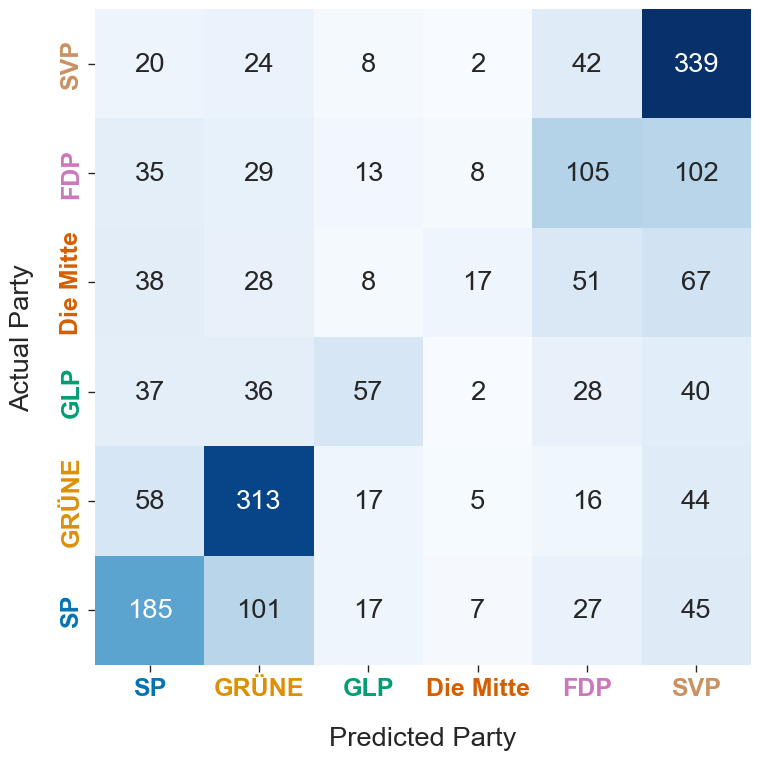

In [17]:
plot_confusion_matrix(y_true.map(party_mapping), [party_mapping[p] for p in y_pred], party_names, figsize=(8, 8), save=False, normalization=None)

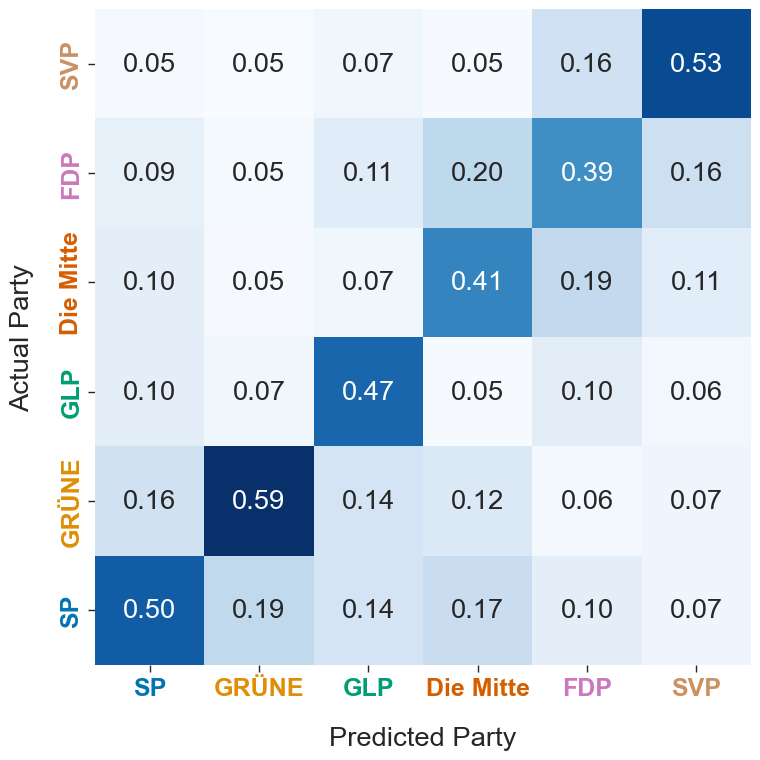

In [18]:
plot_confusion_matrix(y_true.map(party_mapping), [party_mapping[p] for p in y_pred], party_names, figsize=(8, 8), save=False, normalization='precision', file_name='precision_matrix.pdf')

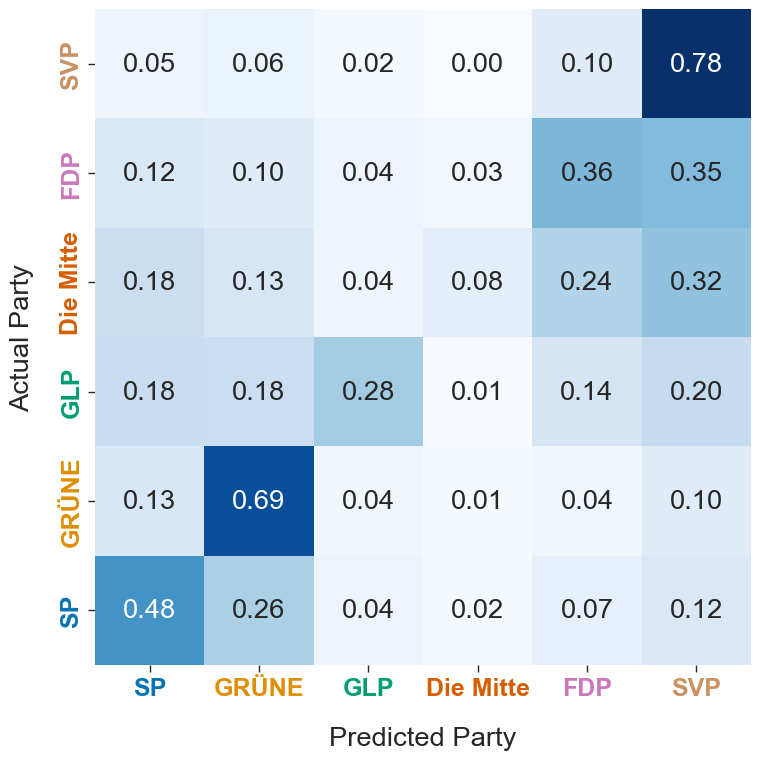

In [19]:
plot_confusion_matrix(y_true.map(party_mapping), [party_mapping[p] for p in y_pred], party_names, figsize=(8, 8), save=False, file_name='recall_matrix.pdf', normalization='recall')

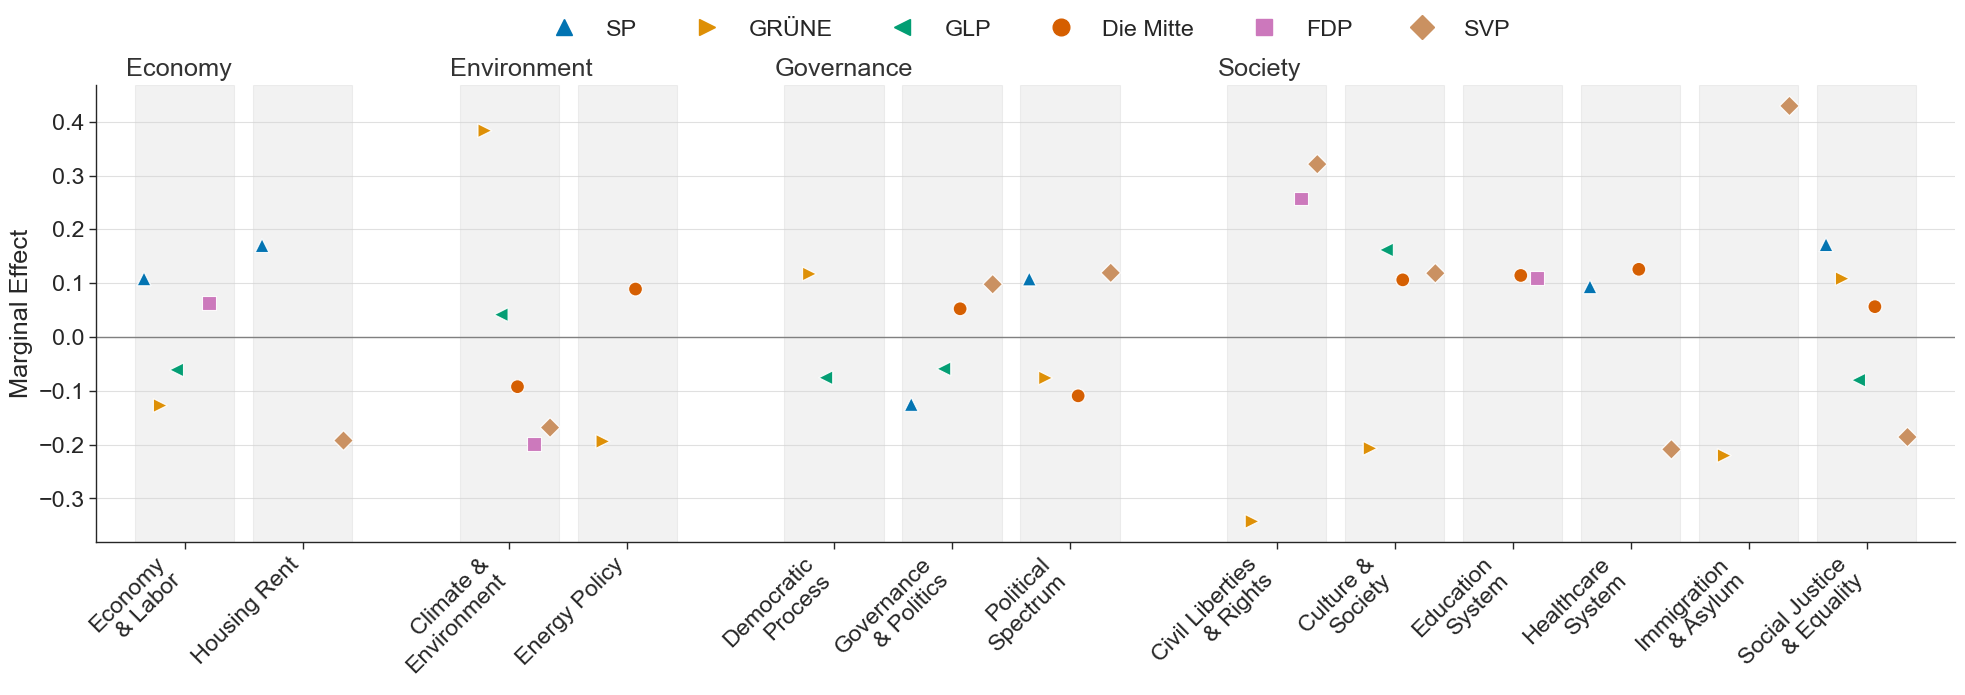

In [20]:
ranked_df = data_coeff['Topics'].copy()
plot_mnlogit_coefficients_fancy(
    ranked_df[ranked_df['Feature'].isin([t.replace('_', ' ') for t in topics_names])],#ranked_df[ranked_df['Feature'].isin([t.replace('_', ' ') for t in topics_names])],
    # party_markers=party_markers,
    # party_colors=party_colors,
    # feature_groups=feature_groups,
    shade_by='feature',
    save=False
)